### Imports

In [30]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


### Reading Data

In [31]:
# read data
data = pd.read_csv('Twitter_Data.csv')

checking for null values

In [32]:
data.isna().sum()

clean_text    4
category      7
dtype: int64

In [33]:
# dropping null rows
data.dropna(inplace=True)
data.category = data.category.astype(np.int32)
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


Category bar plot

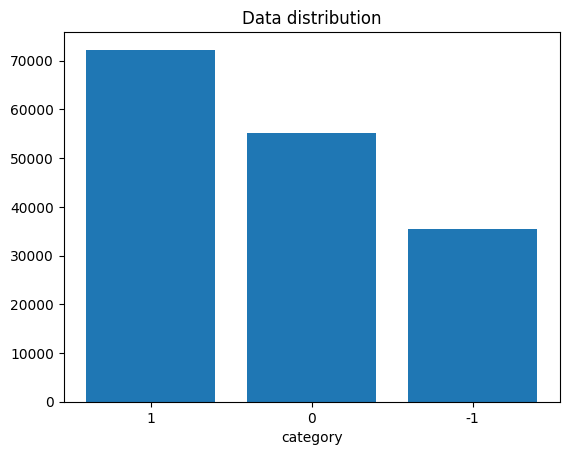

In [34]:
category_counts = data['category'].value_counts()
plt.bar([str(i) for i in category_counts.keys()], category_counts.values)
plt.title("Data distribution")
plt.xlabel("category")
plt.show()

Train test split

In [35]:
# train test split
x_train,  x_test, y_train, y_test = train_test_split(data, data.category, test_size=0.1)

### Preprocessing

In [36]:
# vocabulary
vocab = dict()
word_frequencies = dict()
punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”'

# preprocessor
def preprocess(sentence, train):
    # removing punctuation
    sentence = sentence.translate(str.maketrans('','', punctuations))  
    
    sentence = sentence.split()
    tokens = []
    for i in range(len(sentence)):
        word = sentence[i].lower()
        if  word.isalnum():
            if word not in vocab and train:
                word_frequencies[word] = 0
            if train:
                word_frequencies[word] += 1
                vocab[word] = True
            tokens.append(word)
    return tokens


In [37]:
# vocabulary
vocab = dict()
word_frequencies = dict()

# applying preprocessor on training and testing data
x_train_p = x_train.clean_text.apply(lambda sentence:preprocess(sentence, True))
x_test_p = x_test.clean_text.apply(lambda sentence:preprocess(sentence, False))

# getting word indices
temp_list = list(vocab.keys())
for i in range(len(temp_list)):
    vocab[temp_list[i]] = i

visualize words and their frequencies

In [38]:
tuples = sorted(word_frequencies.items(), key=lambda kv: kv[1], reverse=True)
words = [t[0] for t in tuples]
frequencies = [t[1] for t in tuples]
word_freq = pd.DataFrame()
word_freq['words'] = words
word_freq['word_freq'] = frequencies

In [39]:
len(word_freq[word_freq['word_freq'] == 1])

61510

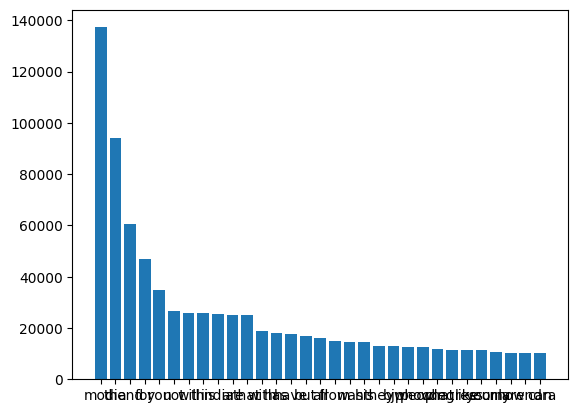

In [40]:
filtered = word_freq[word_freq['word_freq'] > 10000]
plt.bar(filtered['words'], filtered['word_freq'])
plt.show()

#### Word cloud visualization

### Converting tokens to vectors

In [41]:
# tokenized data to vectors
min_freq = 15
max_freq = 20000
vocab_list = list(vocab.keys())
vocab_final = dict()
i = 0
for key in vocab_list:
    if word_frequencies[key] > min_freq and word_frequencies[key] < max_freq:
        vocab_final[key] = i
        i+=1

row = 0
def vectorize_csr(data):
    global row
    sparse_data = []
    sparse_row = []
    sparse_col = []
    # matrix[sparse_row[i], sparse_col[i]] = sparse_data[i]

    def push_to_train_sparse(words):
        global row
        
        for word in words:
            if word in vocab_final:
                # if word frequency is b/w 15 and 9000 then mark that dimension as 1 else 0
                sparse_data.append(1)
                sparse_row.append(row)
                sparse_col.append(vocab_final[word])
        row += 1
        return words
    temp = data.apply(push_to_train_sparse)
    row = 0
    return csr_matrix((sparse_data, (sparse_row, sparse_col)), shape=(len(data), len(vocab_final)))


In [42]:
# data converted to sparse matrix form
x_train_csr = vectorize_csr(x_train_p)
x_test_csr = vectorize_csr(x_test_p)

In [43]:
print(x_train_csr.shape)
print(x_test_csr.shape)

(146672, 9720)
(16297, 9720)


### Classification Algorithm

#### Logistic Regression

In [44]:
# Logistic
# training
classifier = LogisticRegression(max_iter=10000, verbose=1)
classifier.fit(x_train_csr, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.4s finished


LogisticRegression(max_iter=10000, verbose=1)

#### Model Evaluation

In [45]:

# testing
predictions = classifier.predict(x_test_csr)
# metrics
accuracy = accuracy_score(y_test, predictions)
con = confusion_matrix(y_test, predictions)
print(f"accuracy = {accuracy}")
print("confusion matrix:\n", con)


accuracy = 0.94949990795852
confusion matrix:
 [[3218  105  256]
 [  50 5339   67]
 [ 240  105 6917]]


In [19]:
sentiments = {-1:"Negative", 0:"Neutral", 1:"Positive"}
def predict(tweet, classifier=classifier):
    tokens = preprocess(tweet, False)
    csr = vectorize_csr(pd.Series([tokens]))
    return sentiments[classifier.predict(csr)[0]]

In [21]:
# while True:
#     tweet = input("Enter Tweet:")
#     print(predict(tweet))